## King’s Super Math Saga experiment

## Problem statement
Super Math Saga is a fictional mobile game. Like other Saga games, players need to beat levels to progress
through a map. At every level, players are faced with a math question they need to answer correctly to pass
to the next level. The game is Free to Play meaning that players can download and play the game for free
but can optionally buy hints on the levels.

In 2017 we ran an experiment (A/B Test) on the game, offering two different game experiences that we
call A and B, group A being the control group where the experience is kept as is, and group B being
the experiment group that is exposed to the new experience. We set the assignment process to randomly
distribute players among the groups: 80% to group A (control) and 20% to group B (test). The experiment
ran from 2017-05-04 to 2017-05-22.

Your assigment is to analyse and summarise the data provided, to determine which of the experiences makes
Super Math Saga a better game. Send us a short (max 3 pages) report, suitable to present to the head
of studio, with your findings and supporting plots, making recommendations for what the game should
implement and any further analysis you think would be valuable. Markdown or notebook is the preferred
report format.

#### Suggested areas for analysis
1. Which metrics do you consider important to look at in this case? What can you say about them in this
A/B test?
2. What sanity checks can you do to be confident in the validity of the test?
3. Compute the average number of gamerounds per player for each group. Can you confidently state
which group has higher engagement?
4. Do different types of players react differently to the treatment?
5. What type of change to the game do you think was tested here?

### Data Description

The assignment table contains players assigned to the A/B test and attributes related to each player.
1. playerid: Unique numeric identifier for each player
2. abtest_group: The group the player was assigned to (A or B)
3. assignment_date: The date when the player was assigned to the test
4. install_date: The date when the player installed the game
5. conversion_date: The date when the player made their first purchase

The activity table contains player activity for each day a player was active.
1. playerid: Unique numeric identifier for each player
2. activity_date: The date of activity
3. purchases: Number of purchases made this day
4. gameends: Number of gamerounds played this day

### Hypothesis Test

Assumptions:

    - Check for normality
    - If normal distribution, check for homogeneity

Steps:

    - Apply Shapiro Test for normality
    - If parametric, apply Levene Test for homogeneity of variances
    - If parametric + homogeneity of variances apply T-Test
    - If parametric - homogeneity of variances apply Welch Test
    - If non-parametric apply Mann Whitney U Test

In [212]:
# define function that checks assumptions and applies appropriate hypothesis test
def hypothesis_test(test, control, alternative="two-sided"):

    # import packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # check for normality:
    ntA = shapiro(test)[1] < 0.05
    ntB = shapiro(control)[1] < 0.05

    if (ntA == False) & (ntB == False): 
        # parametric test
        # check for homogeneity
        leveneTest = stats.levene(test, control)[1] < 0.05

        if leveneTest == False: # homogeneus
            ttest = stats.ttest_ind(test, control, equal_var=True, alternative=alternative)
        else: # heterogeneous
            ttest = stats.ttest_ind(test, control, equal_var=False, alternative=alternative)
    else:
        # non-parametric test
        ttest = stats.mannwhitneyu(test, control, alternative=alternative)

    return ttest

### Packages

In [187]:
# import packages

# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# GCP
import pandas_gbq
import db_dtypes

# Hypothesis Testing
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind

# Configuration
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Data Extraction & Prep

In [53]:
# define function to query data from gcp and transform it into df
def gcp2df(query):
    project_id = 'king-ds-recruit-candidate-635'
    return pd.read_gbq(query, project_id=project_id, dialect='standard')

In [181]:
query = ('''
    WITH

    activity AS (
    SELECT playerid, SUM(purchases) AS total_purchases, SUM(gameends) as total_gameends
        FROM `king-ds-recruit-candidate-635.abtest.activity` 
        WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
        GROUP BY playerid
    ),

    joinTables AS (
    SELECT ass.*, ac.total_gameends, ac.total_purchases
    FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
    LEFT JOIN  activity AS ac
    ON ass.playerid=ac.playerid
    )

    SELECT * EXCEPT(abtest_group),
    CASE abtest_group
      WHEN "A" THEN "control"
      ELSE "test"
      END
      AS abtest_group
    FROM joinTables
    ''')

df = gcp2df(query)
#df = pd.read_csv("../../../king.csv", index_col=0)

In [56]:
 # format date variables into datetime
df[["assignment_date", "install_date", "conversion_date"]] = df[["assignment_date", "install_date", 
                                                                "conversion_date"]].apply(pd.to_datetime)

In [ ]:
# create more meaningful and actionable variables form datetime variables
df["days_since_installed"] = (df.assignment_date.max() - df.install_date).dt.days # time since a player installed the game in days
df["days_to_convert"] = (df.conversion_date - df.install_date).dt.days # time it takes players to convert after installing the game in days

In [262]:
# create a player_type variable that segments players by days_since_installed
conditions = [
    (df.days_since_installed <= 19),
    (df.days_since_installed > 19) & (df.days_since_installed <= 90),
    (df.days_since_installed > 90)]
values = ["newbie", "experienced", "OG"]
df["player_type"] = np.select(conditions, values)

In [222]:
# split control and test results
control_results = df[df["abtest_group"]=="A"]
test_results = df[df["abtest_group"]=="B"]

In [ ]:
query1 = ('''
    WITH

    activity AS (
    SELECT *
        FROM `king-ds-recruit-candidate-635.abtest.activity` 
        WHERE activity_date BETWEEN "2017-05-04" AND "2017-05-22"
    ),

    joinTables AS (
    SELECT ass.playerid, ass.abtest_group, ac.activity_date, ac.gameends, ac.purchases, 
    FROM `king-ds-recruit-candidate-635.abtest.assignment` AS ass
    LEFT JOIN  activity AS ac
    ON ass.playerid=ac.playerid
    ),

    avg_by_date AS (
    SELECT abtest_group, activity_date, AVG(gameends) AS avg_gameends, STDDEV(gameends) AS std_gameends, 
        SUM(gameends) AS n_gameends, AVG(purchases) AS avg_purchases, STDDEV(purchases) AS std_purchases, 
        SUM(purchases) AS n_purchases
    FROM joinTables
    GROUP BY 1, 2
    ORDER BY activity_date, abtest_group
    )

    SELECT *
    FROM avg_by_date
    ''')

df1 = gcp2df(query1)

## 2. Metric Choice

Invariant metrics: *

    - playerid
    - days_since_installed

Evaluation metrics:

    - total_gameends (engagement)
    - total_purchases (monetization)
    - share of paying players (monetization)
    - days_to_convert (monetization)


*Invariant metrics are those which should not change across control and experiment groups. If players were randomly assigned, we would expect the distributions of these metrics to stay consistent between the test and control sets, or else there is something fundamentally wrong with the experiment setup.

In [215]:
df.head() # contains aggregated gameround and purchase data for the whole experiment

,playerid,abtest_group,assignment_date,install_date,conversion_date,total_gameends,total_purchases,days_since_installed,days_to_conversion,experiment_day
0,32570096,A,2017-05-04,2016-11-20,NaT,104,0,183,NaN,0
1,17717330,A,2017-05-04,2016-06-26,NaT,89,0,330,NaN,0
2,17669260,A,2017-05-04,2016-06-26,NaT,282,0,330,NaN,0
3,43380436,A,2017-05-04,2017-03-08,NaT,305,0,75,NaN,0
4,46708692,A,2017-05-04,2017-04-10,NaT,134,0,42,NaN,0


In [64]:
df.conversion_date.isna().value_counts(normalize=True)

True     0.972324
False    0.027676
Name: conversion_date, dtype: float64

Only about 2.8% of the players make purchases.

On the left we see that most active players have installed the game within the last month. 

On the right we see that most paying users will make their first purchase during the first few days of donwloading and playing the game.

*An active player is one that has logged in during the duration of the AB test.  

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(df.days_since_installed, bins=20, density=True)
ax[0].set_xlabel("Days")
ax[0].set_ylabel("Proportion of Players")
ax[0].set_title("Proportion of Players by time_since_installed")
ax[1].hist(df.days_to_conversion, bins=20, density=True)
ax[1].set_xlabel("Days")
ax[1].set_ylabel("Proportion of Players")
ax[1].set_title("Proportion of Players by time_to_convert")
plt.show()

#### What can we say about our chosen evaluation metrics?

In [96]:
df[["total_gameends", "total_purchases"]].describe()

,total_gameends,total_purchases
count,1.033106e+07,1.033106e+07
mean,1.579491e+02,3.714809e-01
std,1.391929e+02,9.515109e+00
min,0.000000e+00,0.000000e+00
25%,9.500000e+01,0.000000e+00
50%,1.290000e+02,0.000000e+00
75%,1.820000e+02,0.000000e+00
max,1.932000e+03,5.690000e+03


There is a high variance between the gamerounds and purchases made by different players. We can see the presence of many outliers.

## 3. Sanity Checks

#### What checks can we do to be confident in the validity of the test?

In [206]:
# Are there duplicated playerids?
df.playerid.duplicated().any()

False

In [30]:
# Do the control and test groups contain 80 and 20 percent of the players respectively?
df.abtest_group.value_counts(normalize=True)

A    0.800074
B    0.199926
Name: abtest_group, dtype: float64

#### Checking invariants: are the distributions of invariant metrics for control and test groups the same?

In [209]:
# playerid
print(df.groupby("abtest_group").playerid.mean())
print(hypothesis_test(control_results.playerid, test_results.playerid))

abtest_group
A    3.497964e+07
B    3.498333e+07
Name: playerid, dtype: float64
MannwhitneyuResult(statistic=8534119846308.0, pvalue=0.6081364652914412)


In [211]:
# days_since_installed
print(df.groupby("abtest_group").days_since_installed.mean())
print(hypothesis_test(control_results.days_since_installed, test_results.days_since_installed))

abtest_group
A    159.306688
B    159.269564
Name: days_since_installed, dtype: float64
MannwhitneyuResult(statistic=8538072968530.0, pvalue=0.6041776844973805)


All the invariant metrics pass the test. The means of the distributions are very similar and we cannot reject that the underlying distribution is the same for the control and test groups. 

Since everything looks alright, we will go on and analyze the results of our evaluation metrics.

## 4. Results Analysis

### Aggregated Data

To consider the results as positive, we would like to see that the change made to the game, aka treatment, will result in a greater engagement and/or number of purchases. 

Thus, our null hypothesis (H0) and alternative hypothesis (Ha) are as follows:  

    - H0: There is no difference in the average number of gamerounds and/or purchases in the test and control groups.
    - Ha: The average number of gamerounds and/or purchases of the test group is greater than the control group.

Since the alternative hypothesis states that the true value of the parameter specified in the null hypothesis is greater than the null hypothesis claims, we will use a right-tailed test.

We choose our significance level to be 0.05. Thus, if p<=0.05, we reject the H0.

Let's first look into the gameround and purchases summary statistics for the different abtest_groups. 

In [153]:
df[["abtest_group", "total_gameends", "total_purchases"]].groupby(by="abtest_group").agg(["count", 
                                                                            "median", "mean", "std", "max"]).style.format('{:.3f}')

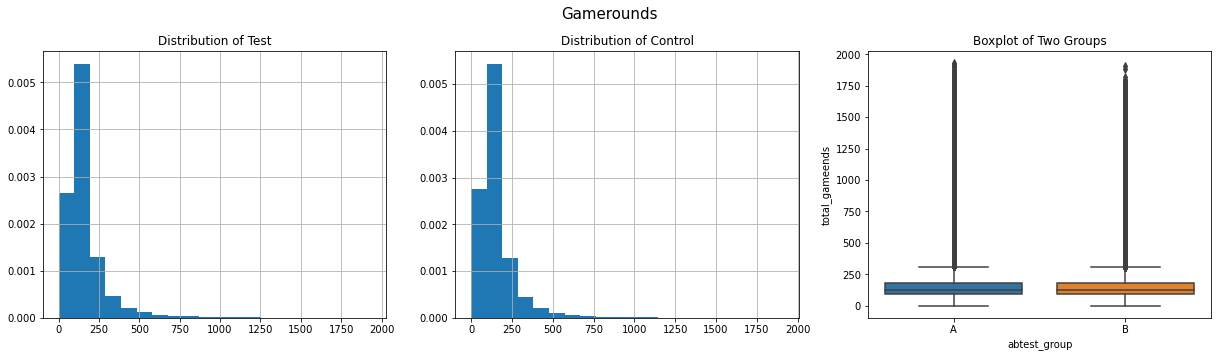

In [173]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
control_results.hist("total_gameends", density=True, bins= 20, ax=ax[0])
test_results.hist("total_gameends", density=True, bins= 20, ax=ax[1])
sns.boxplot(x="abtest_group", y="total_gameends", data=df, ax=ax[2])

fig.suptitle("Gamerounds", fontsize=15)
ax[0].set_title("Distribution of Test", fontsize = 12)
ax[1].set_title("Distribution of Control", fontsize = 12)
ax[2].set_title("Boxplot of Two Groups", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

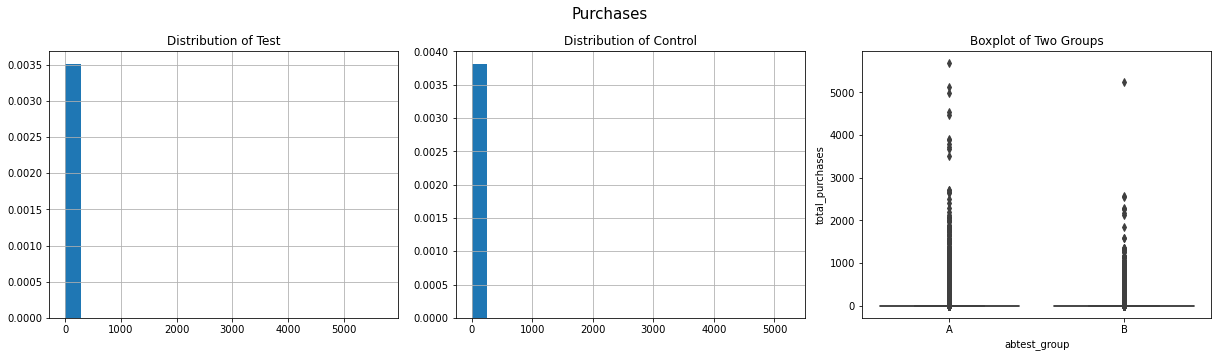

In [172]:
fig, ax = plt.subplots(1, 3, figsize=(17, 5))
control_results.hist("total_purchases", density=True, bins=20, ax=ax[0])
test_results.hist("total_purchases", density=True, bins= 20, ax=ax[1])
sns.boxplot(x="abtest_group", y="total_purchases", data=df, ax=ax[2])

fig.suptitle("Purchases", fontsize=15)
ax[0].set_title("Distribution of Test", fontsize = 12)
ax[1].set_title("Distribution of Control", fontsize = 12)
ax[2].set_title("Boxplot of Two Groups", fontsize = 12)
plt.tight_layout(pad = 1)
plt.show()

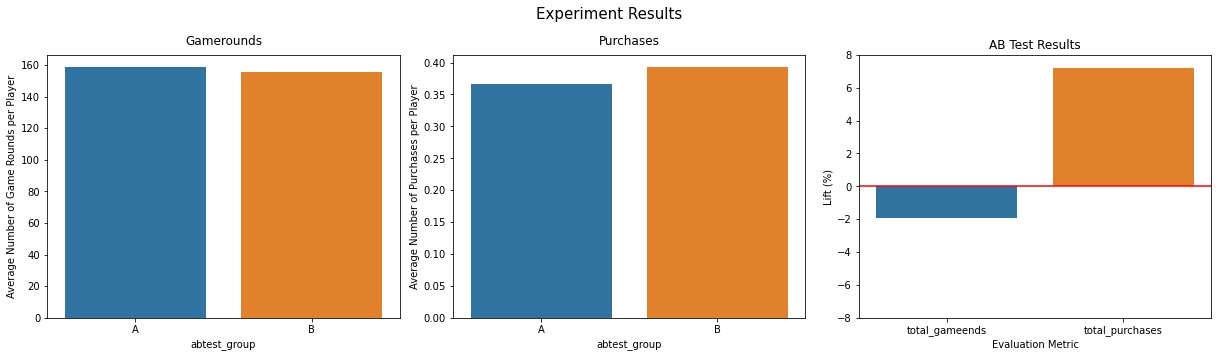

In [186]:
grouped_df = df[["abtest_group", "total_gameends", "total_purchases"]].groupby(df["abtest_group"]).mean()
grouped_df_lift = (grouped_df.loc["B"] - grouped_df.loc["A"]) / grouped_df.loc["A"]

fig, ax = plt.subplots(1, 3, figsize=(17, 5))
sns.barplot(x=grouped_df.total_gameends.index, y=grouped_df.total_gameends, ax=ax[0])
sns.barplot(x=grouped_df.total_purchases.index, y=grouped_df.total_purchases, ax=ax[1])
sns.barplot(x=grouped_df_lift.index, y=grouped_df_lift*100, ax=ax[2])

fig.suptitle("Experiment Results", fontsize=15)
ax[0].set_title("Gamerounds", pad=10)
ax[0].set_ylabel("Average Number of Game Rounds per Player")
ax[1].set_title("Purchases", pad=10)
ax[1].set_ylabel("Average Number of Purchases per Player")
ax[2].set_ylim(-8, 8)
ax[2].set_title("AB Test Results")
ax[2].set_xlabel("Evaluation Metric")
ax[2].set_ylabel("Lift (%)")
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout(pad = 1)
plt.show()

It would seem that our treatment has resulted in a decrease in the average number of gamerounds per player of around 2% (bummer!), but a substantial increase of around 7% in the average number of purchases made. 

To confirm these results, we will perform hypothesis tests.

In [192]:
hypothesis_test(test_results["total_gameends"], control_results["total_gameends"], alternative="less")

MannwhitneyuResult(statistic=8373836786400.0, pvalue=0.0)

In [200]:
hypothesis_test(test_results["total_purchases"], control_results["total_purchases"], alternative="greater")

MannwhitneyuResult(statistic=8536180046875.0, pvalue=0.4901617437975493)

We also need to how that the average number of gamerounds and purchases evolve during the experiment. After launching a new game feature, there may be early transitional effects of the changes introduced in the variants. Looking at the daily averages, rather than the total averages may yield some interesting information.

### Daily Data

In [216]:
df1.head()  # contains the average number of gamerounds and purchases made each day of the experiment

,abtest_group,activity_date,avg_gameends,std_gameends,n_gameends,avg_purchases,std_purchases,n_purchases
0,A,2017-05-04,13.179551,10.238376,68597770,0.030555,0.757338,159035
1,B,2017-05-04,13.119000,10.180584,17040715,0.031852,0.775842,41374
2,A,2017-05-05,13.186148,10.250823,68498045,0.030470,0.768134,158282
3,B,2017-05-05,13.003362,10.096645,16868794,0.033394,0.772663,43321
4,A,2017-05-06,13.182186,10.235810,68755819,0.030389,0.771736,158504


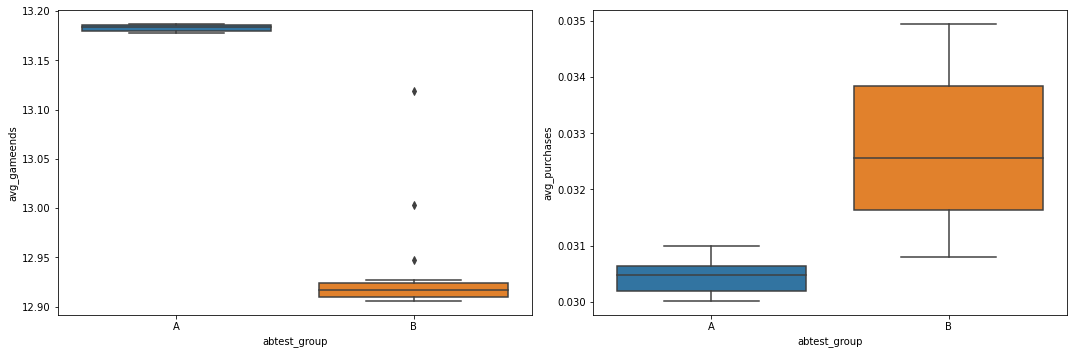

In [250]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(x="abtest_group", y="avg_gameends", data=df1, ax=ax[0])
sns.boxplot(x="abtest_group", y="avg_purchases", data=df1, ax=ax[1])
plt.tight_layout(pad=1)
plt.show()

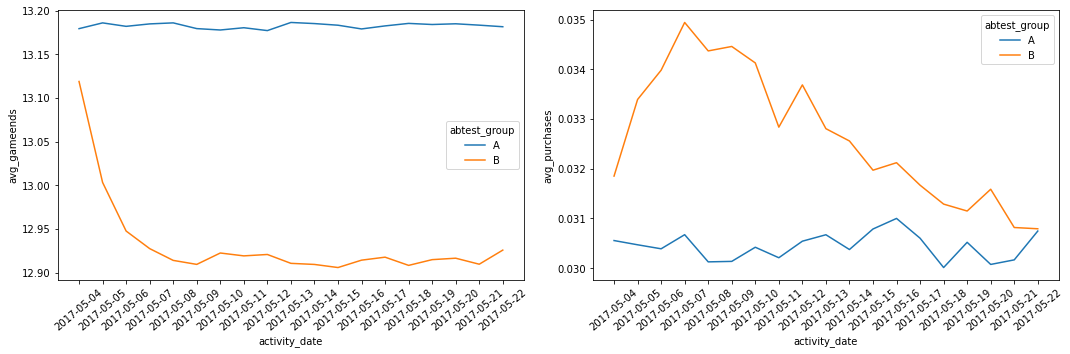

In [251]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
xticklabels = df1.activity_date.unique()
sns.lineplot(x="activity_date", y="avg_gameends", hue="abtest_group", data=df1, ax=ax[0])
sns.lineplot(x="activity_date", y="avg_purchases", hue="abtest_group", data=df1, ax=ax[1])
ax[0].set_xticklabels(xticklabels, rotation=40)
ax[1].set_xticklabels(xticklabels, rotation=40)
plt.tight_layout(pad=1)
plt.show()

Indeed, on the right we see that the average number of daily purchases has a negative trend over time. By the end of the experiment, the purchases of the test group are equal to those in the control group, indicating that the 7% lift in the average number of purchases is likely to be transitory. To take more meaningful conclusions, we should wait for the purchases to stabilize. 

On the left, we see that average number of gamerounds of the test group decreases right away and keeps constant, so we are more certain that the treatment has a negative effect on player engagement. 

### Analysis by Player Type

Do different types of players react differently to the treatment?

In [263]:
player_types = df[["abtest_group", "player_type", "total_gameends", "total_purchases"]].groupby(by=["abtest_group", 
                                                                                    "player_type"]).agg(np.mean).reset_index()
player_types

,abtest_group,player_type,total_gameends,total_purchases
0,A,OG,184.112059,0.427444
1,A,experienced,170.987525,0.389854
2,A,newbie,64.948765,0.150142
3,B,OG,180.576797,0.455691
4,B,experienced,167.774378,0.428025
5,B,newbie,63.739933,0.155587


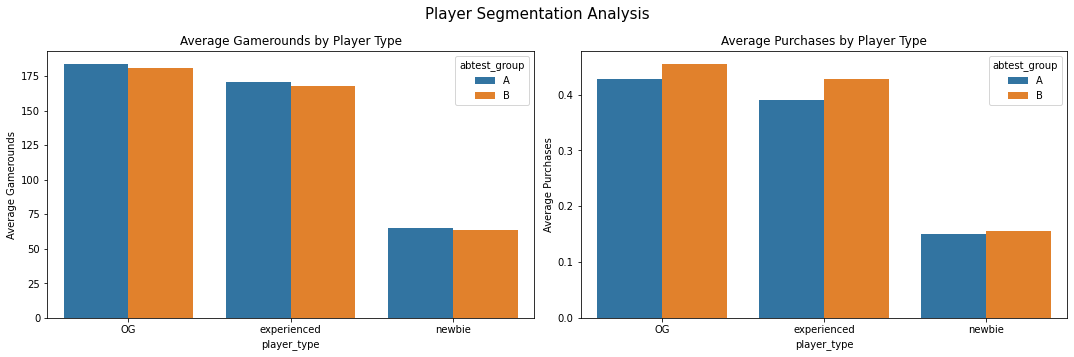

In [264]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x="player_type", y="total_gameends", hue="abtest_group", data=player_types, ax=ax[0])
sns.barplot(x="player_type", y="total_purchases", hue="abtest_group", data=player_types, ax=ax[1])

fig.suptitle("Player Segmentation Analysis", fontsize=15)
ax[0].set_title("Average Gamerounds by Player Type")
ax[0].set_ylabel("Average Gamerounds")
ax[1].set_title("Average Purchases by Player Type")
ax[1].set_ylabel("Average Purchases")
plt.tight_layout(pad=1)
plt.show()

The treatment's engagement and monetization lift appears less extreme for newbies for both gamerounds and purchases. Newbies are those that have installed the game after the start of the ab test and thus had never seen the control version of the game. Thus suggests that 

## Conclusion

In this particular experiment, we can conclude that the change that has been introduced did turn out to be an improvement over the control variant. Rather, we feel that the new variant performed a bit worse than control. It is important to note though, that the analysis did not indicate that there is statistically significant difference between the variants.

To make the most out of A/B tests, we suggest game developers to go beyond the binary statement of having a winner or not, and study every aspect of the results – winning probabilities, the improvement over control statistics, etc.

In [27]:
def ttest(xbar_test, s_test, n_test, xbar_control, s_control, n_control, alternative="two_sided"):
    from scipy.stats import t
    t_stat_list, p_value_list = [], []
    xbar_test.reset_index(drop=True, inplace=True)
    for i in range(len(xbar_test)): 
        delta = xbar_test[i] - xbar_control[i]
        pooled_se = np.sqrt(s_test[i] ** 2 / n_test[i] + s_control[i] ** 2 / n_control[i])
        t_stat = delta / pooled_se
        degrees_of_freedom = n_test[i] + n_control[i] -2

        if alternative=="two_sided": p_value = t.sf(abs(t_stat), df=degrees_of_freedom)*2
        elif alternative=="greater": p_value = t.sf(t_stat, df=degrees_of_freedom)
        elif alternative=="less": p_value = 1 - t.sf(t_stat, df=degrees_of_freedom)
        t_stat_list.append(t_stat)
        p_value_list.append(p_value)

    return t_stat_list, p_value_list

In [44]:
xbar_test, s_test, n_test = test_results["avg_gameends"], test_results["std_gameends"], test_results["n_gameends"]
xbar_control, s_control, n_control = control_results["avg_gameends"], control_results["std_gameends"], control_results["n_gameends"]
xbar_test.reset_index(drop=True, inplace=True)
s_test.reset_index(drop=True, inplace=True)
n_test.reset_index(drop=True, inplace=True)
xbar_control.reset_index(drop=True, inplace=True)
s_control.reset_index(drop=True, inplace=True)
n_control.reset_index(drop=True, inplace=True)
gameends_t_stat_list, gameends_p_value_list = ttest(xbar_test, s_test, n_test, xbar_control, s_control, 
                                                    n_control, alternative="greater")

In [47]:
xbar_test, s_test, n_test = test_results["avg_purchases"], test_results["std_purchases"], test_results["n_purchases"]
xbar_control, s_control, n_control = control_results["avg_purchases"], control_results["std_purchases"], control_results["n_purchases"]
xbar_test.reset_index(drop=True, inplace=True)
s_test.reset_index(drop=True, inplace=True)
n_test.reset_index(drop=True, inplace=True)
xbar_control.reset_index(drop=True, inplace=True)
s_control.reset_index(drop=True, inplace=True)
n_control.reset_index(drop=True, inplace=True)
purchases_t_stat_list, purchases_p_value_list = ttest(xbar_test, s_test, n_test, xbar_control, s_control, 
                                                    n_control, alternative="greater")

<ipython-input-150-131d1462a213>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(x, rotation=40)
<ipython-input-150-131d1462a213>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(x, rotation=40)


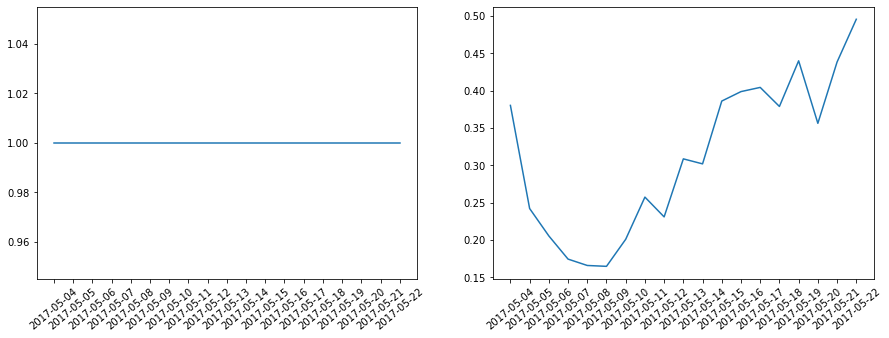

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
x = df1.activity_date.unique()
sns.lineplot(x=x, y=gameends_p_value_list, ax=ax[0])
sns.lineplot(x=x, y=purchases_p_value_list, ax=ax[1])
ax[0].set_xticklabels(x, rotation=40)
ax[1].set_xticklabels(x, rotation=40)
plt.show()

5. What type of change to the game do you think was tested here?

Factor: color
Variants: blue, red

Will updating the UI increase our number of purchases?

Purchases / conversion: make the game easier to play?

More easier questions, so that the user can feel like they are good at the game, before getting stuck and having to pay for hints

PARAMETRIC TESTS
The name “parametric” means that these tests are based on assumption that data has a distribution of a certain form (normal or T distribution), and therefore we can use certain parameters of that distribution (mean, standard deviation) to compare test groups. (ztest, ttest, ANOVA)

T-tests are handy parametric hypothesis tests in statistics when you want to compare means. You can compare a sample mean to a hypothesized or target value using a one-sample t-test. You can compare the means of two groups with a two-sample t-test. If you have two groups with paired observations (e.g., before and after measurements, or control and test measurements), use the paired t-test.

Using a sample standard deviation to estimate the standard error is computationally easier than using bootstrapping. However, to correct for the approximation, you need to use a t-distribution when transforming the test statistic to get the p-value.

normal distribution -> t distribution with infinite degrees of freedom
dof: maximum number of logically independent observations in the data sample. 

for a two sample case: dof = n_test + n_control -2